# LAB 4 MOS: Método Simplex y sus Variaciones

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 1: Implementación del Método Simplex Estándar

$$Maximizar \quad Z = 3x_1 + 2x_2 + 5x_3$$

Restricciones:

$$x_1 + x_2 + x_3 \leq 100$$
$$2x_1 + x_2 + x_3 \leq 150$$
$$x_1 + 4x_2 + 2x_3 \leq 80$$
$$x_1, x_2, x_3 \geq 0$$

### Convertir el problema a forma estandar con variables de holgura:

$$Z = 3x_1 + 2x_2 + 5x_3 + 0s_1 + 0s_2 + 0s_3$$

Restricciones:

$$x_1 + x_2 + x_3 + s_1 = 100$$
$$2x_1 + x_2 + x_3 + s_2 = 150$$
$$x_1 + 4x_2 + 2x_3 + s_3 = 80$$
$$x_1, x_2, x_3, s_1, s_2, s_3 \geq 0$$

### Implementación de Simplex:

Tabla Simplex Inicial:
+------+------+------+------+------+------+-----+
|   x1 |   x2 |   x3 |   s1 |   s2 |   s3 |   b |
+======+======+======+======+======+======+=====+
|    1 |    1 |    1 |    1 |    0 |    0 | 100 |
+------+------+------+------+------+------+-----+
|    2 |    1 |    1 |    0 |    1 |    0 | 150 |
+------+------+------+------+------+------+-----+
|    1 |    4 |    2 |    0 |    0 |    1 |  80 |
+------+------+------+------+------+------+-----+
|   -3 |   -2 |   -5 |    0 |    0 |    0 |   0 |
+------+------+------+------+------+------+-----+


Iteración 1: Variable que entra: 2, Variable que sale: 2
Tabla Simplex actualizada:
+------+------+------+------+------+------+-----+
|   x1 |   x2 |   x3 |   s1 |   s2 |   s3 |   b |
+======+======+======+======+======+======+=====+
|  0.5 |   -1 |    0 |    1 |    0 | -0.5 |  60 |
+------+------+------+------+------+------+-----+
|  1.5 |   -1 |    0 |    0 |    1 | -0.5 | 110 |
+------+------+------+------+------+-----

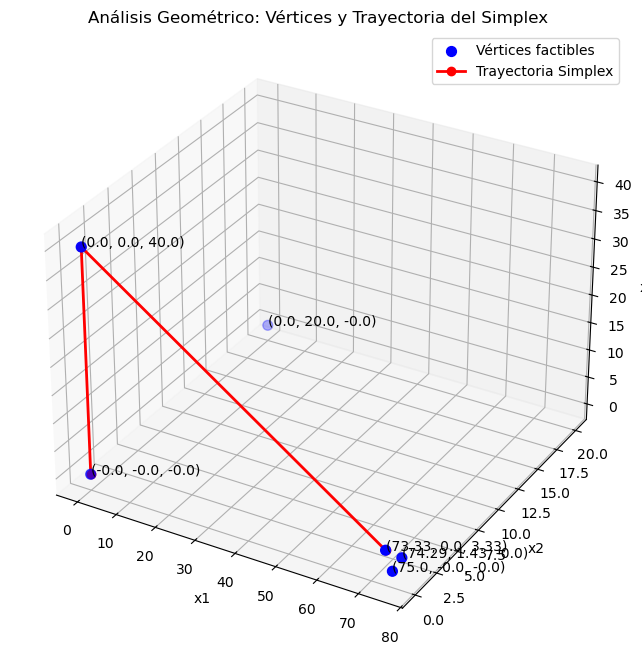

In [31]:
import numpy as np
from tabulate import tabulate
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def simplex(c, A, b, imprimir_iteraciones=True):
    m, n = A.shape  # m es el número de restricciones, n es el número de variables
    # tabla que contendra las iteraciones
    tableau = np.hstack((A, np.eye(m), b.reshape(-1, 1))) # Restricciones A, identidad de holgura y vector b
    obj_row = np.hstack((-c, np.zeros(m+1))) # Coeficientes de funcion objetivo
    tableau = np.vstack((tableau, obj_row)) # Anadirlos a la tabla
    basis = list(range(n, n+m)) # Variables basicas iniciales
    iterates = [] # Guarda las soluciones para cada iteracion

    # Funcion para extraer solucion de la tabla
    def extraer_solucion(tableau, basis):
        sol = np.zeros(n) # Solucion inicializada en cero
        for i in range(m):
            if basis[i] < n: # Si variable basica esta entre variables originales
                sol[basis[i]] = tableau[i, -1] # Se asigna el valor solucion a esa posicion
        return sol

    iterates.append(extraer_solucion(tableau, basis)) # Tomar solucion inicial

    if imprimir_iteraciones: # Imprimir la iteracion 0 (tabulate)
        print("Tabla Simplex Inicial:")
        headers = [f"x{i+1}" for i in range(n)] + [f"s{i+1}" for i in range(m)] + ["b"]
        print(tabulate(tableau, headers=headers, tablefmt="grid"))
        print("\n")

    # Ciclo principal para simplex
    iteration = 0 # Contador de iteraciones
    while True:
        iteration += 1
        obj_coeff = tableau[-1, :-1] # Tomar los coeficientes de la función objetivo
        if all(obj_coeff >= 0): # Si todos los coeficientes no son negativos, se llego a la solucion
            break # Salir
        
        # Se selecciona la variable de entrada
        entering = np.argmin(obj_coeff) # La mas negativa
        column = tableau[:-1, entering] # Se toma su columna
        if all(column <= 0): # Si todos sus valores son negativos, el problema es ilimitado
            raise Exception("El problema es ilimitado.") # Salir (con exception)

        #Para la variable que sale, calcular las razones
        ratios = [tableau[i, -1] / tableau[i, entering] if tableau[i, entering] > 0 else np.inf for i in range(m)]
        # Seleccionar la que tiene razon minima
        leaving = np.argmin(ratios)

        # Mostrar la variable que entra y sale
        if imprimir_iteraciones:
            print(f"Iteración {iteration}: Variable que entra: {entering}, Variable que sale: {leaving}")

        # Pivote de la iteracion
        pivot = tableau[leaving, entering]
        tableau[leaving, :] /= pivot # Normalizar la fila del pivote
        # Ciclo para actualizar las filas
        for i in range(m+1):
            if i != leaving:
                tableau[i, :] -= tableau[i, entering] * tableau[leaving, :] # Gauss - Jordan
        
        basis[leaving] = entering # Actualizar las variables basicas
        iterates.append(extraer_solucion(tableau, basis)) # Guardar la solucion de esa iteracion

        # Imprimir la iteracion i (tabulate)
        if imprimir_iteraciones:
            print("Tabla Simplex actualizada:")
            print(tabulate(tableau, headers=headers, tablefmt="grid"))
            print("\n")

    # Fuera del ciclo
    solution = extraer_solucion(tableau, basis) # Tomar la solucion final
    objective_value = tableau[-1, -1] # # Tomar el valor optimo
    return solution, objective_value, tableau, iterates

# Obtener vertices factibles (Usado solo para graficar)
def obtener_vertices(A_feas, b_feas):
    vertices = [] # Lista para vertices
    num_cons = A_feas.shape[0] # Numero de restricciones
    for idx in itertools.combinations(range(num_cons), 3): # Tomar 3 restricciones a la vez
        A_sub = A_feas[list(idx), :]
        b_sub = b_feas[list(idx)]
        try:
            sol = np.linalg.solve(A_sub, b_sub) # Solución del sistema
        except np.linalg.LinAlgError:
            continue
        if np.all(np.dot(A_feas, sol) - b_feas <= 1e-5): # Si es una solucion valida
            sol_rounded = np.round(sol, decimals=5) # Redondear a 5 decimales
            if not any(np.allclose(sol_rounded, v) for v in vertices): # No duplicados
                vertices.append(sol_rounded) # Tomar ese vector
    return np.array(vertices)

# Problema
c = np.array([3, 2, 5]) # Coeficientes de funcion objetivo
A = np.array([ # Coefienctes de restricciones
    [1, 1, 1],
    [2, 1, 1],
    [1, 4, 2]
])
b = np.array([100, 150, 80]) # Lado derecho

# Ejecutar simplex
solution, objective_value, final_tableau, iterates = simplex(c, A, b, imprimir_iteraciones=True)


#----------------------- Mostrar Resultados--------------------------------------#
# Solucion y valor objetivo
print("Solución óptima:")
for i, val in enumerate(solution, start=1):
    print(f"  x{i} = {round(val,2)}")
print(f"\nValor óptimo de Z: {round(objective_value,2)}")


# Auxiliar para hallar vertices para visualizacion
A_feas = np.array([
    [ 1,  1,  1],
    [ 2,  1,  1],
    [ 1,  4,  2],
    [-1,  0,  0],
    [ 0, -1,  0],
    [ 0,  0, -1]
])
b_feas = np.array([100, 150, 80, 0, 0, 0])

# Obtener vertices factibles
vertices = obtener_vertices(A_feas, b_feas)

# Grafico en 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Mostrar los vertices factibles en el grafico
if len(vertices) > 0:
    ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], color='blue', label='Vértices factibles', s=50)
    for v in vertices:
        ax.text(v[0], v[1], v[2], f"({round(v[0],2)}, {round(v[1],2)}, {round(v[2],2)})", color='black')

# Graficar la solucion de las iteraciones como una trayectoria en el grafico
iterates = np.array(iterates)
ax.plot(iterates[:,0], iterates[:,1], iterates[:,2], marker='o', color='red', label='Trayectoria Simplex', linewidth=2)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
ax.set_title('Análisis Geométrico: Vértices y Trayectoria del Simplex')
ax.legend()
plt.show()


En la gráfica, los puntos azules representan los vértices factibles, es decir, las intersecciones de las restricciones en el espacio tridimensional. La trayectoria en rojo muestra cómo el algoritmo Simplex se desplaza de un vértice a otro hasta encontrar el óptimo (iniciando en (0,0,0)).

Los puntos con coordenadas (0,0,40),(0,20,0), etc., representan otros vértices del espacio factible que no fueron óptimos

La solución optima del problema planteado se encuentra en el punto (73.33, 0, 3.33) con un valor de Z = 236.67

## Problema 2: Implementación del Método Simplex Dual Phase

$$Minimizar \quad Z = 5x_1 + 4x_2 + 3x_3$$

Restricciones:

$$2x_1 + x_2 - x_3 = 10$$
$$x_1 - 3x_2 + 2x_3 \geq 5$$
$$x_1 + x_2 + x_3 \leq 15$$
$$x_1, x_2, x_3 \geq 0$$

###  Convertir el problema a la forma estándar

$$Maximizar -Z = -5x_1 - 4x_2 - 3x_3 + 0s_1 + 0s_2$$

Restricciones:

$$2x_1 + x_2 - x_3 = 10$$
$$x_1 - 3x_2 + 2x_3 - s_1 = 5$$
$$x_1 + x_2 + x_3 + s_2 = 15$$
$$x_1, x_2, x_3, s_1, s_2 \geq 0$$

### Implementación

In [32]:
import numpy as np
from tabulate import tabulate

def simple_dual_phase(c, A, b, art_vars, verbose=True):
    """
    Implementa el método Two-Phase Simplex asumiendo que el problema ya está en forma estándar.
    
    Parámetros:
      - c: vector de coeficientes de la función objetivo (extendido a todas las variables, incluyendo slack/exceso y artificiales)
            (Ejemplo para el Problema 2: [5, 4, 3, 0, 0, 0])
      - A: matriz de coeficientes de las restricciones (ya en forma de igualdad)
      - b: vector del lado derecho
      - art_vars: lista de índices (0-indexados) de las columnas correspondientes a variables artificiales.
      - verbose: si True, imprime tablas e iteraciones.
    
    El problema original es de minimización:
          Minimizar Z = c^T x
    Se asume que el problema se transformó a forma estándar:
          Maximizar -Z = -c^T x
    Se ejecutan dos fases:
      Fase I: Se busca una solución básica factible (minimizando la suma de las variables artificiales)
      Fase II: Se optimiza la función objetivo original (recordando la transformación a maximización de -Z)
      
    Retorna:
      - solution: vector con los valores de las variables de decisión originales (se asume que estas son las primeras)
      - optimal_value: valor óptimo del problema original de minimización.
      - tableau_final: el tableau final de la Fase II.
      - iterates: lista con los tableaux de iteraciones de la Fase II.
    """
    m, n_full = A.shape
    # Construir el tableau inicial (restricciones)
    tableau = np.hstack((A, b.reshape(-1, 1)))  # tamaño: (m x (n_full+1))
    
    # --- Fase I ---
    # La función objetivo en Fase I es: maximizar - (suma de las variables artificiales)
    phase1_obj = np.zeros(n_full + 1)
    for j in art_vars:
        phase1_obj[j] = -1
    tableau_phase1 = np.vstack([tableau, phase1_obj])
    
    # Para "limpiar" la fila objetivo, se deben anular las artificiales en base.
    # Se supone que, si en alguna restricción la columna de una variable es la columna identidad, ésta es básica.
    basic_vars = _get_initial_basic_vars(tableau)
    for i, j in enumerate(basic_vars):
        if j in art_vars:
            tableau_phase1[-1, :] += tableau_phase1[i, :]
    
    if verbose:
        print("=== Tableau Fase I inicial ===")
        headers = [f"x{j+1}" for j in range(n_full)] + ["b"]
        print(tabulate(tableau_phase1, headers=headers, tablefmt="grid"))
        print("\n")
    
    tableau_phase1, basic_vars_phase1, phase1_iters = simplex_iterations(tableau_phase1, verbose, phase="Fase I")
    
    if verbose:
        print("=== Fin Fase I ===")
        print("Valor óptimo de la función Fase I:", tableau_phase1[-1, -1])
        print("\n")
    
    # Si el óptimo de la Fase I es mayor que 0, el problema es infactible.
    if abs(tableau_phase1[-1, -1]) > 1e-8:
        raise Exception("El problema es infactible (valor de Fase I != 0).")
    
    # --- Preparar Fase II ---
    # Se eliminan las columnas de variables artificiales.
    keep_cols = [j for j in range(n_full) if j not in art_vars]
    # Se arma el tableau para Fase II: se conserva el bloque de restricciones y el RHS,
    # y se descarta la fila objetivo de Fase I.
    tableau_phase2 = tableau_phase1[:-1, :][:, keep_cols + [-1]]
    n_phase2 = tableau_phase2.shape[1] - 1  # número de columnas (sin contar b)
    
    # Se arma la nueva fila objetivo para Fase II.
    # Recordar que en la transformación se trabajó con maximizar -Z.
    phase2_obj = np.zeros(n_phase2 + 1)
    # Se asume que los primeros k elementos de c corresponden a las variables originales.
    # Aquí se toma c_restringido = c[keep_cols]
    c_phase2 = np.array(c)[keep_cols]
    phase2_obj[:n_phase2] = -c_phase2  # ya que se maximiza -Z
    tableau_phase2 = np.vstack([tableau_phase2, phase2_obj])
    
    # Ajuste de la fila objetivo de Fase II: para cada variable básica, se restan sus
    # contribuciones para dejar coeficientes cero en la fila objetivo.
    basic_vars_phase2 = _get_initial_basic_vars(tableau_phase2[:-1, :])
    for i, j in enumerate(basic_vars_phase2):
        if j != -1:
            phase2_obj -= tableau_phase2[i, :] * tableau_phase2[-1, j]
    tableau_phase2[-1, :] = phase2_obj
    
    if verbose:
        print("=== Tableau Fase II inicial ===")
        headers_phase2 = [f"x{j+1}" for j in range(n_phase2)] + ["b"]
        print(tabulate(tableau_phase2, headers=headers_phase2, tablefmt="grid"))
        print("\n")
    
    tableau_phase2, basic_vars_phase2, phase2_iters = simplex_iterations(tableau_phase2, verbose, phase="Fase II")
    
    # --- Extraer solución ---
    # Se asume que las variables de decisión originales son las primeras (por ejemplo, 3 en el Problema 2)
    n_original = 3
    solution = np.zeros(n_original)
    m2 = tableau_phase2.shape[0] - 1
    for (i, j) in basic_vars_phase2:
        if j < n_original:
            solution[j] = tableau_phase2[i, -1]
    # El valor óptimo de la función (recordando que se resolvió maximizando -Z)
    optimal_value = -tableau_phase2[-1, -1]
    
    if verbose:
        print("=== Fin Fase II ===")
        print("Solución óptima (variables de decisión):")
        for i, val in enumerate(solution, start=1):
            print(f"  x{i} = {round(val, 4)}")
        print(f"\nValor óptimo de Z: {round(optimal_value, 4)}")
    
    return solution, optimal_value, tableau_phase2, phase2_iters

# Función auxiliar para determinar variables básicas iniciales a partir de columnas de identidad.
def _get_initial_basic_vars(tableau):
    """
    Busca en el bloque de restricciones (sin la fila objetivo) columnas que sean columnas
    identidad. Devuelve una lista de tamaño m (número de restricciones) en donde cada posición
    contiene el índice de la variable básica para esa fila o -1 si no se encontró.
    """
    m, n_plus1 = tableau.shape
    m = m - 1  # sin contar la fila objetivo
    n = n_plus1 - 1
    basic_vars = [-1] * m
    for j in range(n):
        col = tableau[:m, j]
        if np.count_nonzero(np.abs(col - 1) < 1e-8) == 1 and np.count_nonzero(np.abs(col) > 1e-8) == 1:
            i = np.where(np.abs(col - 1) < 1e-8)[0][0]
            basic_vars[i] = j
    return basic_vars

# Función auxiliar para realizar las iteraciones del Simplex.
def simplex_iterations(tableau, verbose, phase="Fase"):
    """
    Ejecuta el método simplex sobre el tableau dado.
    Retorna:
      - tableau: el tableau final.
      - basic_vars: lista de tuplas (fila, columna) indicando la variable básica de cada restricción.
      - iterates: lista con copias del tableau en cada iteración.
    """
    m = tableau.shape[0] - 1  # número de restricciones
    n = tableau.shape[1] - 1  # número de variables (sin contar b)
    basic_vars = _get_initial_basic_vars(tableau)
    
    iterates = []
    iteration = 0
    while True:
        iteration += 1
        obj_coeff = tableau[-1, :n]
        if np.all(obj_coeff >= -1e-8):
            break
        entering = np.argmin(obj_coeff)
        col = tableau[:m, entering]
        if np.all(col <= 1e-8):
            raise Exception("Problema ilimitado durante " + phase)
        ratios = []
        for i in range(m):
            if tableau[i, entering] > 1e-8:
                ratios.append(tableau[i, -1] / tableau[i, entering])
            else:
                ratios.append(np.inf)
        leaving = np.argmin(ratios)
        if verbose:
            entering_name = f"x{entering+1}"
            leaving_name = f"x{basic_vars[leaving]+1}" if basic_vars[leaving] != -1 else "N/A"
            print(f"{phase} - Iteración {iteration}: entra {entering_name}, sale {leaving_name}")
        pivot = tableau[leaving, entering]
        tableau[leaving, :] = tableau[leaving, :] / pivot
        for i in range(m+1):
            if i != leaving:
                tableau[i, :] = tableau[i, :] - tableau[i, entering] * tableau[leaving, :]
        basic_vars[leaving] = entering
        iterates.append(tableau.copy())
        if verbose:
            headers = [f"x{j+1}" for j in range(n)] + ["b"]
            print(tabulate(tableau, headers=headers, tablefmt="grid"))
            print("\n")
    # Convertir basic_vars a lista de tuplas (fila, columna)
    basic_vars_tuples = [(i, basic_vars[i]) for i in range(m)]
    return tableau, basic_vars_tuples, iterates

# ============================================================================
# Ejemplo: Problema 2
#
# Se tiene el problema:
#
#   Minimizar  Z = 5x1 + 4x2 + 3x3
#
# Restricciones:
#   2x1 +   x2 -   x3         = 10
#   x1 - 3x2 + 2x3 - s1          =  5   (>= se resolvió restando s1)
#   x1 +  x2 +  x3 + s2          = 15   (<= se resolvió sumando s2)
#
# Y para la restricción de igualdad (la 1), se agregó una variable artificial:
#   2x1 + x2 - x3 + a1 = 10
#
# La forma estándar para el Simplex es:
#   Maximizar -Z = -5x1 - 4x2 - 3x3 + 0·s1 + 0·s2 + 0·a1
#
# Datos para el problema:
c_std = [5, 4, 3, 0, 0, 0]  # Orden: x1, x2, x3, s1, s2, a1
A_std = np.array([
    [2,  1, -1,  0,  0,  1],   # restricción 1: se agregó a1
    [1, -3,  2, -1,  0,  0],   # restricción 2: s1 aparece con signo negativo
    [1,  1,  1,  0,  1,  0]    # restricción 3: s2 con coeficiente 1
])
b_std = np.array([10, 5, 15])
# La única variable artificial es a1, que es la columna de índice 5.
artificial_vars = [5]

# Ejecutar el método Two-Phase:
#solution, optimal_value, tableau_final, iterates = simple_dual_phase(c_std, A_std, b_std, artificial_vars, verbose=True)


## Problema 3: Comparación de Rendimiento con GLPK/Pyomo

### Implementación con Pyomo

In [33]:
from pyomo.environ import ConcreteModel, Var, Objective, ConstraintList, NonNegativeReals, SolverFactory, maximize
import re

def obtener_iteraciones_glpk(logfile="glpk_out.txt"):
    with open(logfile, 'r') as f:
        lineas = f.readlines()
        for linea in reversed(lineas):
            # Buscar línea con formato tipo: "*     4: obj = ..."
            match = re.search(r"\*\s*(\d+):\s+obj\s*=", linea)
            if match:
                return int(match.group(1))
    return None


def resolver_con_glpk(c, A, b):
    model = ConcreteModel()

    n_vars = len(c)
    n_constraints = len(b)

    # Variables de decisión
    model.x = Var(range(n_vars), domain=NonNegativeReals)

    # Función objetivo: Max Z = c1*x1 + c2*x2 + ...
    model.obj = Objective(expr=sum(c[i] * model.x[i] for i in range(n_vars)), sense=maximize)

    # Restricciones
    model.constraints = ConstraintList()
    for j in range(n_constraints):
        expr = sum(A[j][i] * model.x[i] for i in range(n_vars))
        model.constraints.add(expr <= b[j])

    # Resolver usando GLPK
    solver = SolverFactory('glpk')
    result = solver.solve(model, logfile = "glpk_out.txt")
    iteraciones = obtener_iteraciones_glpk("glpk_out.txt")

    # Extraer resultados
    solucion = [model.x[i].value for i in range(n_vars)]
    valor_objetivo = model.obj()

    return solucion, valor_objetivo, iteraciones

# Variables del problema
c = np.array([5, 8, 3, 7, 6, 9, 4, 10, 2, 11])
A = np.array([
    [1, 2, 1, 1, 0, 0, 3, 1, 2, 1],
    [2, 1, 0, 2, 1, 1, 0, 3, 1, 2],
    [1, 1, 2, 0, 2, 1, 1, 0, 3, 1],
    [0, 2, 1, 1, 1, 0, 2, 1, 1, 1],
    [2, 0, 1, 1, 1, 2, 1, 1, 0, 2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 2, 1, 0, 1, 2, 1, 1, 0],
    [1, 0, 1, 2, 1, 0, 1, 2, 1, 1]
])
b = np.array([50, 60, 55, 40, 45, 70, 65, 50])

### Solución con diferentes implementaciones

In [34]:
import time

def comparar_metodos(c, A, b):
    print("Comparando métodos...\n")
    resultados = []
    # --- GLPK ---
    inicio = time.time()
    solucion_glpk, valor_glpk, iteraciones = resolver_con_glpk(c, A, b)
    tiempo_glpk = round(time.time() - inicio,7)
    resultados.append(["GLPK", round(valor_glpk, 5), iteraciones, tiempo_glpk])

    # --- Simplex Estándar ---
    inicio = time.time()
    solucion_std, valor_std, tableu, iteraciones_std = simplex(c, A, b, False)
    tiempo_std = round(time.time() - inicio, 7)
    resultados.append(["Simplex Estándar", round(valor_std, 5), len(iteraciones_std), tiempo_std])

    # --- Dual Phase ---
    #inicio = time.time()
    #solucion_dual, valor_dual, iteraciones_dual = simplex_dual(c, A, b)
    #tiempo_dual = round(time.time() - inicio,7)
    #resultados.append(["Dual Phase", round(valor_dual, 5), iteraciones_dual, tiempo_dual])
    headers = ["Método", "Valor Óptimo", "Iteraciones", "Tiempo (s)"]
    print(tabulate(resultados, headers=headers, tablefmt="fancy_grid"))

    # Mostrar tabla de soluciones (valores de x)
    soluciones_tabla = []
    n = len(solucion_glpk)
    for i in range(n):
        soluciones_tabla.append([
            f"x{i+1}",
            round(solucion_glpk[i], 4),
            round(solucion_std[i], 4),
            0 # TODO Corregir esto cuando este dual phase bien
            #round(solucion_dual[i], 4)
        ])

    headers_sol = ["Variable", "GLPK", "Simplex Estándar", "Dual Phase"]
    print("\nSoluciones por variable:")
    print(tabulate(soluciones_tabla, headers=headers_sol, tablefmt="fancy_grid"))

comparar_metodos (c,A,b)


Comparando métodos...



╒══════════════════╤════════════════╤═══════════════╤══════════════╕
│ Método           │   Valor Óptimo │   Iteraciones │   Tiempo (s) │
╞══════════════════╪════════════════╪═══════════════╪══════════════╡
│ GLPK             │        375.625 │             4 │    0.131783  │
├──────────────────┼────────────────┼───────────────┼──────────────┤
│ Simplex Estándar │        375.625 │             5 │    0.0009971 │
╘══════════════════╧════════════════╧═══════════════╧══════════════╛

Soluciones por variable:
╒════════════╤════════╤════════════════════╤══════════════╕
│ Variable   │   GLPK │   Simplex Estándar │   Dual Phase │
╞════════════╪════════╪════════════════════╪══════════════╡
│ x1         │  0     │              0     │            0 │
├────────────┼────────┼────────────────────┼──────────────┤
│ x2         │ 15.625 │             15.625 │            0 │
├────────────┼────────┼────────────────────┼──────────────┤
│ x3         │  0     │              0     │            0 │
├──────────

## Problema 4: Análisis de Sensibilidad de Programación Lineal